In [1]:
import sys
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
sys.path.append('../src/')
from utils import *
from config import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram, norm, beta, multivariate_normal
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

%load_ext autoreload
%autoreload 2

## Data generation

## Features

1- Lets generate $N$ samples from a group of $d_{ind}$ marginally uniformly distributed random variable $x_1,\dots, x_{d_{ind}}$ and indipendent from each other.

2- Then lets generate $N$ samples from a group of $d_{corr}$ marginally uniformly distributed random variable $x_{d_{ind}+1},\dots, x_{d_{corr}}$, which we make correlated via a Gaussian copula (Nelsen 2007) with correlation parameter $\rho$:

In [2]:
seed_everything(1)

N=1000
d_ind = 5
d_corr = 10
ρ = 0.95

features_ind = [f'x{i}' for i in range(1,d_ind+1)]
features_corr = [f'x{i}' for i in range(d_ind+1,d_ind+d_corr+1)]
features = features_ind + features_corr

Σ1 = np.eye(d_ind)
Σ2 = np.full(shape=(d_corr,d_corr), fill_value=ρ) + np.eye(d_corr) * (1-ρ)
Σ = block_diag(Σ1, Σ2)
X = multivariate_normal([0]*Σ.shape[0], Σ).rvs(size=N)
X = norm.cdf(X)

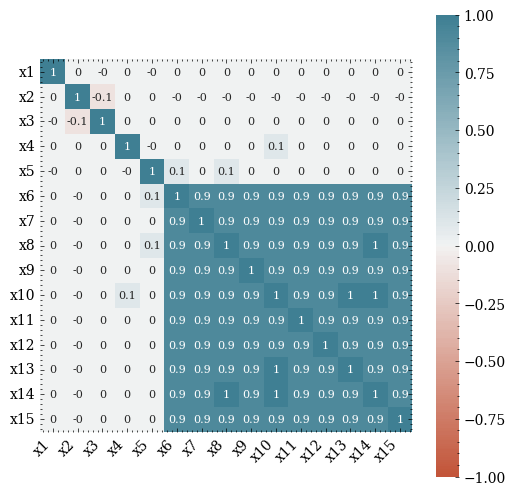

In [3]:
fig_params.update({'figure.figsize': [6,6]})
rcParams.update(fig_params)
ax = sns.heatmap(pd.DataFrame(data=X, columns=features).corr().round(1), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),
                 square=True, annot=True, annot_kws={"fontsize":8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Target

Lets generate the target variable as a linear combination of the group of indipendent input features and **one** from the group of correlated input features, with additive gaussian noise. 

$$
y = \sum_{i=1}^{d_{ind}} \beta_ix_i + \beta_jx_j + \epsilon , \quad j\in\{d_{ind}+1,\dots, d_{corr}\}
$$

with $\epsilon \sim \mathcal{N}(\mu_y=0,\sigma_y^2)$ and the $\beta$ coefficients defined below.

In [4]:
seed_everything(1)

β_ind = [1.0]*d_ind
β_corr = 1.5
μy = 0
σy = 0.5

β = np.array(β_ind + [β_corr])
y = X[:,:d_ind+1] @ β + σy * np.random.randn(N) + μy

In [5]:
seed_everything(1)

target = 'y'
df = pd.DataFrame(data=np.hstack([X, y.reshape(-1,1)]), columns= features + [target])
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)
model = RandomForestRegressor(max_features=0.7)
model.fit(X_train, y_train);

In [6]:
print(f'RF train R2: {model.score(X_train, y_train):.3f}')
print(f'RF test R2: {model.score(X_test, y_test):.3f}')

RF train R2: 0.947
RF test R2: 0.671


In [7]:
seed_everything(1)

result = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=0, n_jobs=-1)
features_ind = [f'x{i}' for i in range(1, d_ind+1)]
features_corr = [f'x{i}' for i in range(d_ind+1, d_ind+d_corr+1)]
features = features_ind + features_corr

idx1 = pd.MultiIndex.from_product([['indipendent'], features_ind])
idx2 = pd.MultiIndex.from_product([['correlated'], features_corr])
idx = pd.MultiIndex.from_tuples(list(idx1.values) + list(idx2.values), names=['type', 'feature'])
imp_df = pd.DataFrame(data=result.importances, index=idx)

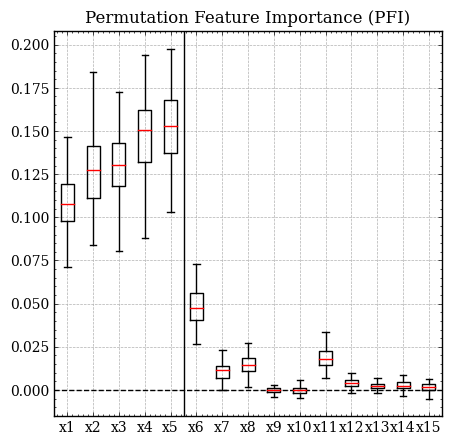

In [8]:
fig_params.update({'figure.figsize': [5,5]})
rcParams.update(fig_params)

boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
capprops = dict(linestyle='-', linewidth=1, color='k')
ax = imp_df.reset_index([0],drop=True).T.boxplot(column=features, showfliers=False,
                                                        boxprops=boxprops, medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops)
ax.axhline(0.0, linestyle='--', color='k')
ax.axvline(5.5, color = 'k', linestyle='-')
ax.set_title('Permutation Feature Importance (PFI)');

## Feature selection

We select the top 5 features based on PFI.

In [9]:
seed_everything(1)

X_train, X_test, y_train, y_test = train_test_split(df[features_ind], df[target], random_state=42)
model = RandomForestRegressor(max_features=0.7)
model.fit(X_train, y_train);

In [10]:
print(f'RF train R2: {model.score(X_train, y_train):.3f}')
print(f'RF test R2: {model.score(X_test, y_test):.3f}')

RF train R2: 0.921
RF test R2: 0.500


## Clustered feature importance

In [14]:
corr_df = df[features].corr(method='pearson')
distance_matrix = 1 - corr_df.abs()
dist_linkage = hierarchy.ward(squareform(distance_matrix))

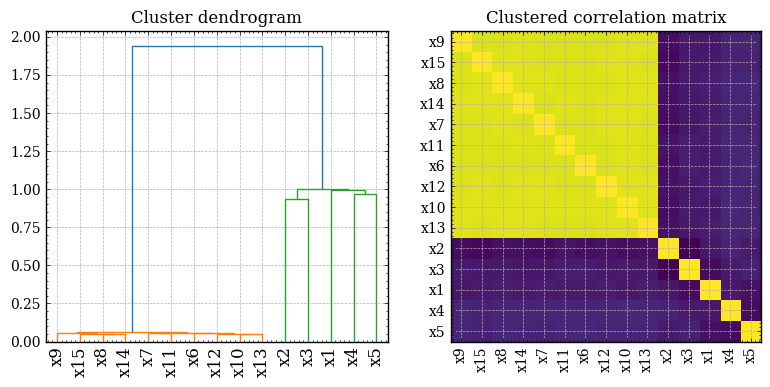

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

dendro = hierarchy.dendrogram(dist_linkage, labels=features, ax=ax1, leaf_rotation=90)
ax1.tick_params(axis='x', which='both', bottom=True, top=True,labelbottom=True)
ax1.set_title('Cluster dendrogram')
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax2.imshow(corr_df.values[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
ax2.set_title('Clustered correlation matrix')
fig.tight_layout()
plt.show()

In [16]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion='distance')
cluster_id_to_feature_names = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_names[cluster_id].append(features[idx])
cluster_id_to_feature_names = dict(sorted(cluster_id_to_feature_names.items()))

In [17]:
cluster_id_to_feature_names

{1: ['x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15'],
 2: ['x2'],
 3: ['x3'],
 4: ['x4'],
 5: ['x5'],
 6: ['x1']}

In [18]:
seed_everything(1)

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)

In [19]:
pd.concat([X_train[cluster_id_to_feature_names[1]], y_train.to_frame()], axis=1).corr()['y'].sort_values(ascending=False)

y      1.000000
x6     0.491224
x8     0.481408
x11    0.478926
x10    0.474615
x7     0.474321
x12    0.470349
x9     0.468008
x14    0.466883
x13    0.461822
x15    0.461333
Name: y, dtype: float64

In [20]:
selected_features = ['x1','x2','x3','x4','x5','x6']

seed_everything(1)

X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df[target], random_state=42)
model = RandomForestRegressor(max_features=0.7)
model.fit(X_train, y_train);

In [21]:
print(f'RF train R2: {model.score(X_train, y_train):.3f}')
print(f'RF test R2: {model.score(X_test, y_test):.3f}')

RF train R2: 0.950
RF test R2: 0.699


In [22]:
seed_everything(1)
result = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=0, n_jobs=-1)
features = selected_features
imp_df = pd.DataFrame(data=result.importances, index=features)

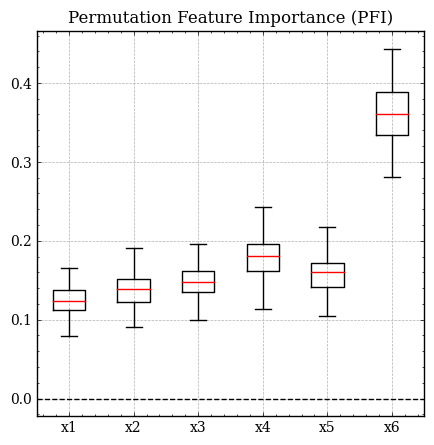

In [23]:
fig_params.update({'figure.figsize': [5,5]})
rcParams.update(fig_params)

boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
whiskerprops = dict(linestyle='-', linewidth=1, color='k')
capprops = dict(linestyle='-', linewidth=1, color='k')
ax = imp_df.T.boxplot(column=selected_features, showfliers=False,
                                                        boxprops=boxprops, medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops)
ax.axhline(0.0, linestyle='--', color='k')
ax.set_title('Permutation Feature Importance (PFI)');

## References

Nelsen, Roger B. An introduction to copulas. Springer Science & Business Media, 2007.

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py